In [4]:
%autoreload 2
%load_ext autoreload

UsageError: Line magic function `%autoreload` not found.


In [22]:
from typing import List
import torch 
from torch import nn
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import pandas as pd 
import seaborn as sns 
import torch.nn.functional as F


def show(tensors: List[torch.Tensor]):
    if not isinstance(tensors, list):
        tensors = [tensors]
    fig, axs = plt.subplots(1, len(tensors), figsize=(5 * len(tensors), 5))

    for i, x in enumerate(tensors):
        sns.heatmap(
            x.detach().numpy(), 
            cmap='rocket_r', 
            cbar=True,
            linewidths=.5,
            ax=axs[i] if len(tensors) > 1 else axs
        )

In [36]:
class Model(nn.Module):
    def __init__(
        self, 
        num_kv_pairs: int = 16,
        d_model: int = 16,
        freeze_embeddings: bool = True,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.embeddings = nn.Embedding(num_kv_pairs, d_model)
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation
    
    def forward(self, x):
        x = self.embeddings(x)
        x1 = self.activation(self.layer1(x))
        x2 = self.layer2(x1)
        y = self.embeddings.weight @ x2.T
        return y, {"x1": x1, "x2": x2}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y)
        return loss, output, meta
        
def learn_mapping(
    num_kv_pairs: int = 16, 
    d_model: int = 16, 
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    device: int = 0, 
    model_cls: type = Model,
    **kwargs
):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False)).to(device)

    model = model_cls(num_kv_pairs=num_kv_pairs, d_model=d_model, **kwargs)
    model.to(device)

    # Define a loss function and an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        loss, output, meta = model.loss(keys, values)    # Forward pass
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if epoch % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
                'accuracy': (output.argmax(dim=1) == values).float().mean().item()
            })
    return metrics[-1], metrics, meta, model, {k: v for k, v in zip(keys, values)}

In [62]:
metrics, _, meta, model, kv = learn_mapping(
    num_kv_pairs=12, 
    d_model=4, 
    pbar=True, 
    num_epochs=6_000,
    log_interval=200,
    device="cpu", 
    model_cls=Model,
    freeze_embeddings=True
)
metrics

  0%|          | 0/6000 [00:00<?, ?it/s]

{'epoch': 5800, 'loss': 0.9041767716407776, 'accuracy': 0.6666666865348816}

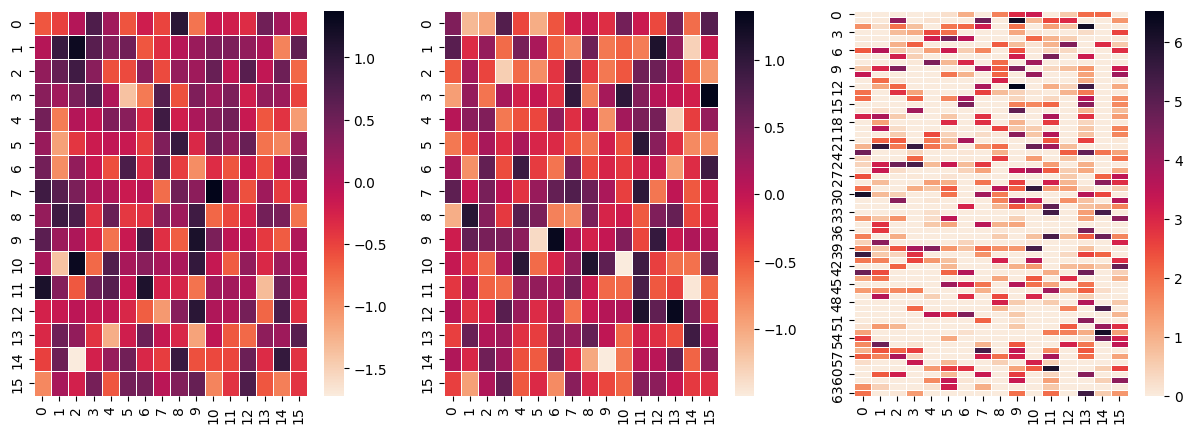

In [43]:
show([model.layer1.weight.data, model.layer2.weight.data, meta["x1"]])

In [53]:
results = []
for num_kv_pairs in [8, 16, 32, 64, 128]:
    metrics, _, meta, model, kv = learn_mapping(
        num_kv_pairs=num_kv_pairs, 
        d_model=16, 
        pbar=True, 
        num_epochs=6_000,
        log_interval=200,
        device="cpu", 
        model_cls=Model,
        freeze_embeddings=True
    )
    results.append(
        {
            "num_kv_pairs": num_kv_pairs,
            "accuracy": metrics["accuracy"],
            "norm": torch.norm(meta["x1"]).item()
        }
    )

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

<Axes: xlabel='num_kv_pairs', ylabel='norm'>

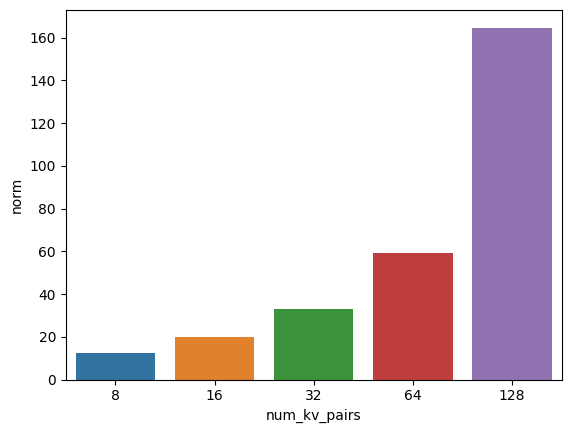

In [55]:
sns.barplot(
    pd.DataFrame(results),
    x="num_kv_pairs",
    y="norm"
)

In [164]:
num_kv_pairs = 16

results = []
for num_kv_pairs in tqdm([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]):
    for d_model in tqdm([4, 8, 16, 32, 64, 128, 256, 512]):
        metrics, _ = learn_mapping(
            num_kv_pairs=num_kv_pairs, 
            d_model=d_model, 
            num_epochs=800
        )
        results.append(
            {
                'num_kv_pairs': num_kv_pairs,
                'd_model': d_model,
                **metrics
            }
        )


100%|██████████| 12/12 [21:00<00:00, 105.08s/it]


In [165]:
df = pd.DataFrame(results)

<Axes: xlabel='d_model', ylabel='num_kv_pairs'>

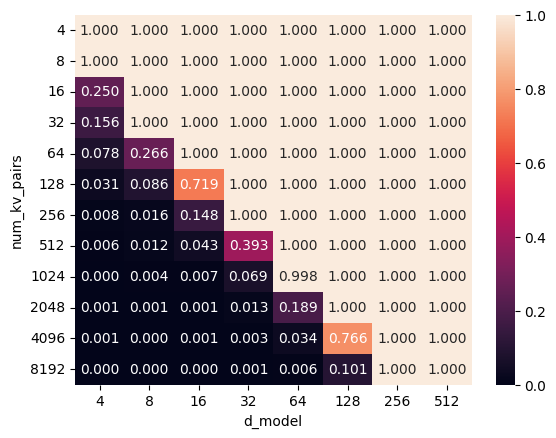

In [166]:
# Pivot the data
pivot_df = df.pivot(index='num_kv_pairs', columns='d_model', values='accuracy')

# Create the heatmap
sns.heatmap(pivot_df, annot=True, fmt=".3f")


/Users/sabrieyuboglu/opt/miniconda3/envs/zoology/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


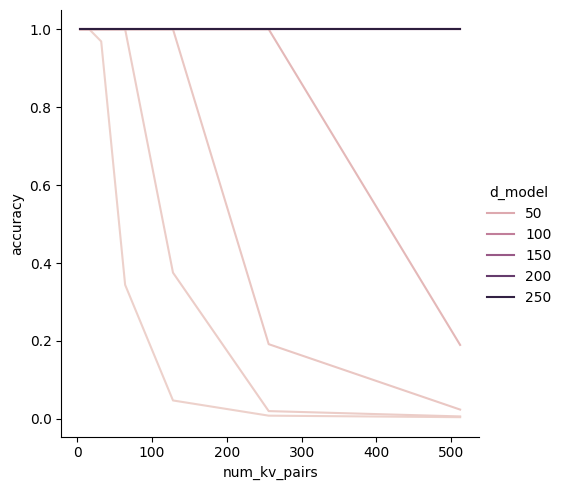

In [87]:
sns.relplot(
    data=df,
    x='num_kv_pairs',
    y='accuracy',
    hue='d_model',
    kind='line'
)

<Axes: >

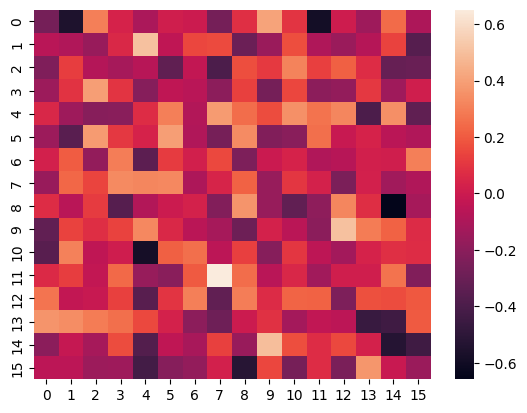

In [63]:

sns.heatmap(layer.layer.weight.detach().numpy())